#Project In Progress
___

# Some installations

In [1]:
!pip -q install tensorboardX

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.7 MB/s eta 0:00:00


In [2]:
!pip -q install ale-py

In [3]:
!pip -q install "gymnasium[atari,accept-rom-license,other]" ale-py

In [4]:
import gymnasium as gym
import ale_py
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import numpy as np
from tensorboardX import SummaryWriter



# Let's Start The Project

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [6]:
gym.register_envs(ale_py)

In [7]:
env=gym.make("ALE/SpaceInvaders-v5",render_mode='human')

In [8]:
image_of_game=env.reset()

In [9]:
frame_dim=image_of_game[0].shape
print(f'The Frame Dimensions Are:{frame_dim}')

The Frame Dimensions Are:(210, 160, 3)


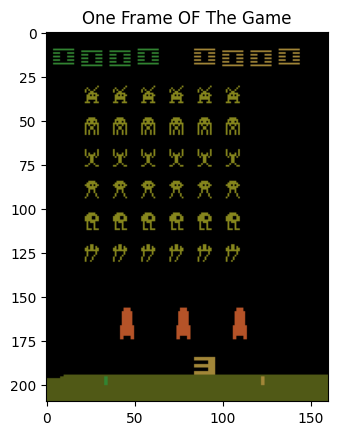

In [10]:
plt.title('One Frame OF The Game')
plt.imshow(image_of_game[0])

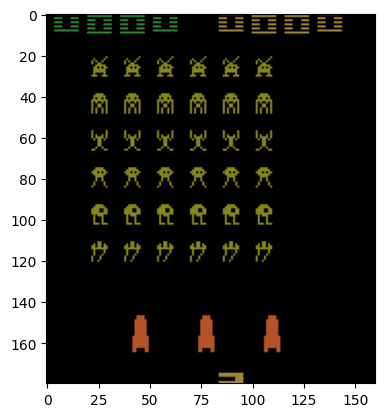

In [11]:
plt.imshow(image_of_game[0][10:190])

In [12]:
num_actions = env.action_space.n
print(f"Number of actions: {num_actions}")

Number of actions: 6



# 0=NOOP, 1=FIRE, 2=RIGHT, 3=LEFT, 4=RIGHTFIRE, 5=LEFTFIRE

In [13]:
env.observation_space

Box(0, 255, (210, 160, 3), uint8)

In [14]:
new_image=env.step(3)

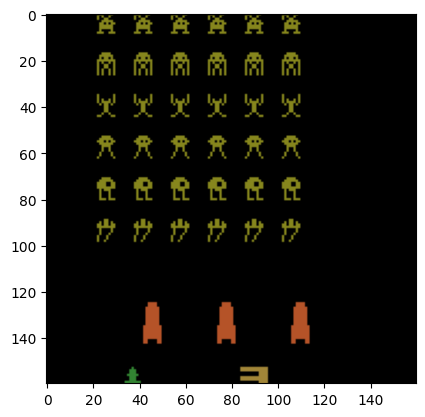

In [15]:
plt.imshow(new_image[0][32:192])

In [16]:
192-32

160